# Inception Neural Network

Welcome to the fourth HDA laboratory! In this notebook, you will implement an advanced architecture: the **Inception-v4 network.** The architecture was proposed by [Google developers](https://arxiv.org/pdf/1602.07261.pdf) for image classification.

**In this assignment, you will:**
- Implement the basic building blocks of Inception-v4. 
- Put together these building blocks to implement and train a state-of-the-art neural network for image classification. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pydot
from PIL import Image
from IPython.display import SVG
from load_utils import *
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
import scipy.misc
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve

# Dataset
For this lab, you will use the [**PatchCamelyon** dataset](https://github.com/basveeling/pcam). It consists of 327.680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating the presence of metastatic tissue.
If the label is `1` it means that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. 

In this notebook, you will use a smaller version of the dataset that consists of 1.200 images. Feel free to download the entire dataset to experiment with it (e.g., if you train the network with more examples, the performance of the designed classifier should increase).

The function `load_data()` defined in `resnet_utils.py`, loads the smaller dataset.

In [2]:
(x_train, y_train, meta_train), (x_test, y_test, meta_test) = load_data()

In [3]:
print('TRAIN SET, images: {}'.format(x_train.shape))
print('TRAIN SET, labels: {}'.format(y_train.shape))
train_length = y_train.shape[0]

print('TEST SET, images: {}'.format(x_test.shape))
print('TEST SET, labels: {}'.format(y_test.shape))
test_length = y_test.shape[0]

TRAIN SET, images: (5000, 96, 96, 3)
TRAIN SET, labels: (5000, 1)
TEST SET, images: (1000, 96, 96, 3)
TEST SET, labels: (1000, 1)


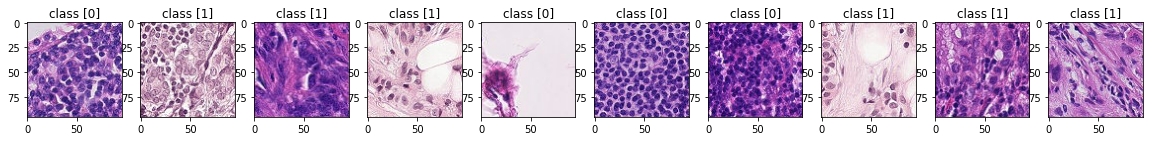

In [4]:
plt.figure(figsize=[20,10])
plt.subplot(1, 10, 1)
    
for i in range(10):
    plt.subplot(1, 10, i+1)
    image = x_train[i, :, :, :]
    plt.imshow(image)
    label = y_train[i]
    plt.title('class '+ str(label))
plt.show()

To train the models we will implement below on the image dataset, we use [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) that generates batches of tensor image data. This class is useful when using image datasets as it allows applying real-time data augmentation. For the test generator we only apply normalization without data augmentation.

In [5]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                             width_shift_range=4,  # randomly shift images horizontally
                             height_shift_range=4,  # randomly shift images vertically 
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=True)  # randomly flip images

In [6]:
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

In [7]:
batch_size = 32
train_steps = int(np.ceil(train_length/batch_size))
test_steps = int(np.ceil(test_length/batch_size))

# Inception network

In a pure Inception network, there are two different block types: the *Inception blocks* and the *Reduction blocks*.

Inception-v4 is composed of three Inception blocks, two Reduction ones and an initial stem block. 

<img src="images/inceptionv4.png" style="width:80%">
<caption><center>  <br> </center></caption>

**Note**: for the last activation we will use ``sigmoid`` with one output neuron (binary classification task).

## 1 - Inception-v4 blocks 
### 1.1 - Convolutional and batch normalization helper function
First of all, here below is implemented the ``conv2d_bn`` helper function that you will use in all the blocks of the Inception v4 network.

Use the following structure:
- CONV2D with $F$ filters of shape ($h$, $w$), stride of ($s_1$, $s_2$). 
- BatchNorm, normalizing the 'channels' axis.  
- ReLU activation function. 

In [8]:
# FUNCTION: conv2d_bn block

def conv2d_bn(X_input, filters, kernel_size, strides, padding='same', activation=None,
              name=None):
    """
    Implementation of a conv block as defined above
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    filters -- integer, defining the number of filters in the CONV layer
    kernel_size -- (f1, f2) tuple of integers, specifying the shape of the CONV kernel
    strides -- integer, specifying the stride to be used
    padding -- padding approach to be used
    name -- name for the layers
    
    Returns:
    X -- output of the conv2d_bn block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'conv_'
    bn_name_base = 'bn_'

    X = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, 
               padding = padding, name = conv_name_base + name, 
               kernel_initializer = glorot_uniform(seed=0))(X_input)
    X = BatchNormalization(axis = 3, name = bn_name_base + name)(X)
    if activation is not None:
        X = Activation(activation)(X)
    return X

### 1.2 - The stem block

The stem block is designed as follows:

<img src="images/stem.png" style="width:70%">
<caption><center> Stem block. </center></caption>

Implement below all the steps by taking advantage of the above implemented ``conv2d_bn`` function for the blue rectangles. The values for the kernel sizes and the strides are specified in each block, use stride 1x1 when it is not specified. Use padding "valid" when the letter *V* appears otherwise use padding "same". E.g., the first layer has the following parameters: 32 filters of shape (3, 3), stride of (2, 2), padding "valid" while the third one is composed of 64 filters of shape (3, 3), stride of (1, 1), padding "same".

For the **Filter concat** layers (orange rectangles), use [tf.concat](https://www.tensorflow.org/api_docs/python/tf/concat) and concatenate along the 'channel' axis (axis=3).

As in laboratory 6, you can add a name for each of the layers. Use 0 as the seed for the random initialization to reproduce the expected output.

**Note** that the last conv block has ``stride = 2`` and the max pooling layer has ``kernel = (3, 3)``


In [55]:
# FUNCTION: stem_block

def stem_block(X_input):
    """
    Implementation of the stem block as defined above
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the stem block, tensor of shape (n_H, n_W, n_C)
    """
    
    ### START CODE HERE ###
    # First conv 
    X = conv2d_bn(X_input, filters=32, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', name='stem_1_1')
    
    # Second conv
    X = conv2d_bn(X, filters=32, kernel_size=(3, 3), strides=1, padding='valid', activation='relu', name='stem_1_2')

    # Third conv
    X = conv2d_bn(X, filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name='stem_1_3')

    # First branch: max pooling
    branch1 = MaxPooling2D(pool_size=3, strides=2, padding='valid')(X)

    # Second branch: conv
    branch2 = conv2d_bn(X, filters=96, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', name='stem_1_4')

    # Concatenate (1) branch1 and branch2 along the channel axis
    X = tf.concat([branch1, branch2], axis=3)

    # First branch: 2 convs
    branch1 = conv2d_bn(X, filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='stem_2_branch1_1')
    branch1 = conv2d_bn(branch1, filters=96, kernel_size=3, strides=1, padding='valid', activation='relu', name='stem_2_branch1_2')
    
    # Second branch: 4 convs
    branch2 = conv2d_bn(X, filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='stem_2_branch2_1')
    branch2 = conv2d_bn(branch2, filters=64, kernel_size=(7, 1), strides=1, padding='same', activation='relu', name='stem_2_branch2_2')
    branch2 = conv2d_bn(branch2, filters=64, kernel_size=(1, 7), strides=1, padding='same', activation='relu', name='stem_2_branch2_3')
    branch2 = conv2d_bn(branch2, filters=96, kernel_size=(3, 3), strides=1, padding='valid', activation='relu', name='stem_2_branch2_4')

    # Concatenate (2) branch1 and branch2 along the channel axis
    X = tf.concat([branch1, branch2], axis=3)

    # First branch: conv
    branch1 = conv2d_bn(X, filters=192, kernel_size=(3, 3), strides=(2, 2), padding='valid', activation='relu', name='stem_3_branch1_1')

    # Second branch: max pooling
    branch2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(X)

    # Concatenate (3) branch1 and branch2 along the channel axis
    X = tf.concat([branch1, branch2], axis=3)

    ### END CODE HERE ###
    
    return X

In [56]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = stem_block(X_inp)
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 10, 10, 384)
out = tf.Tensor([0.01137415 0.         0.01842471 0.        ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.01137414   0.         0.01842478   0.         ]
        </td>
    </tr>

</table>

### 1.3 - The Inception-A block

Implement below the Inception-A block as detailed in the figure:

<img src="images/inception_A.png" style="width:50%">
<caption><center> Inception-A block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``

In [72]:
# FUNCTION: Inception-A block

def inception_a_block(X_input, base_name):
    """
    Implementation of the Inception-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(X_input)
    branch1 = conv2d_bn(branch1, filters=96, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepA_1'+base_name)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=96, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepA_2'+base_name)
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepA_3_1'+base_name)
    branch3 = conv2d_bn(branch3, filters=96, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name='incepA_3_2'+base_name)

    # Branch 4
    branch4 = conv2d_bn(X_input, filters=64, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepA_4_1'+base_name)
    branch4 = conv2d_bn(branch4, filters=96, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepA_4_2'+base_name)
    branch4 = conv2d_bn(branch4, filters=96, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepA_4_3'+base_name)

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat([branch1, branch2, branch3, branch4], axis=3)
    
    ### END CODE HERE ###
    
    return X

In [54]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = inception_a_block(X_inp, 'a')
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 100, 100, 384)
out = tf.Tensor([0.09909102 0.18648542 0.01800423 0.        ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.09909103 0.18648545 0.01800423 0.        ]
        </td>
    </tr>

</table>

### 1.4 - The Inception-B block

Implement below the Inception-B block as detailed in the figure:

<img src="images/inception_B.png" style="width:50%">
<caption><center> Inception-B block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``. In the third branch, the last convolutional layer has kernel of size (7, 1).

In [79]:
# FUNCTION: Inception-B block

def inception_b_block(X_input, base_name):
    """
    Implementation of the Inception-B block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(X_input)
    branch1 = conv2d_bn(branch1, filters=128, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepB_1'+base_name)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=384, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepB_2'+base_name)
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=192, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepB_3_1'+base_name)
    branch3 = conv2d_bn(branch3, filters=224, kernel_size=(1, 7), strides=1, padding='same', activation='relu', name='incepB_3_2'+base_name)
    branch3 = conv2d_bn(branch3, filters=256, kernel_size=(7, 1), strides=1, padding='same', activation='relu', name='incepB_3_3'+base_name)

    # Branch 4
    branch4 = conv2d_bn(X_input, filters=192, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepB_4_1'+base_name)
    branch4 = conv2d_bn(branch4, filters=192, kernel_size=(1, 7), strides=1, padding='same', activation='relu', name='incepB_4_2'+base_name)
    branch4 = conv2d_bn(branch4, filters=224, kernel_size=(7, 1), strides=1, padding='same', activation='relu', name='incepB_4_3'+base_name)
    branch4 = conv2d_bn(branch4, filters=224, kernel_size=(1, 7), strides=1, padding='same', activation='relu', name='incepB_4_4'+base_name)
    branch4 = conv2d_bn(branch4, filters=256, kernel_size=(7, 1), strides=1, padding='same', activation='relu', name='incepB_4_5'+base_name)

    # Concatenate branch1, branch2, branch3 and branch4 along the channel axis
    X = tf.concat([branch1, branch2, branch3, branch4], axis=3)
    
    ### END CODE HERE ###
    
    return X

In [70]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = inception_b_block(X_inp, 'b')
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 100, 100, 1024)
out = tf.Tensor([0.09139543 0.11461768 0.         0.0327634 ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.09139545 0.11461768 0.         0.03276341 ]
        </td>
    </tr>

</table>

### 1.5 - The Inception-C block

Implement below the Inception-C block as detailed in the figure:

<img src="images/inception_C.png" style="width:50%">
<caption><center> Inception-C block. </center></caption>

**Note** The average pooling has ``pool_size = (3, 3)`` and ``strides = (1, 1)``.

In [74]:
# FUNCTION: Inception-C block

def inception_c_block(X_input, base_name):
    """
    Implementation of the Inception-C block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = AveragePooling2D(pool_size=(3, 3), strides=(1, 1), padding='same')(X_input)
    branch1 = conv2d_bn(branch1, filters=256, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepC_1'+base_name)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=256, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepC_2'+base_name)
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=384, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepC_3_1'+base_name)
    
    branch3_1 = conv2d_bn(branch3, filters=256, kernel_size=(1, 3), strides=1, padding='same', activation='relu', name='incepC_3_2_1'+base_name)
    branch3_2 = conv2d_bn(branch3, filters=256, kernel_size=(3, 1), strides=1, padding='same', activation='relu', name='incepC_3_2_2'+base_name)

    # Branch 4
    branch4 = conv2d_bn(X_input, filters=384, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='incepC_4_1'+base_name)
    branch4 = conv2d_bn(branch4, filters=448, kernel_size=(1, 3), strides=1, padding='same', activation='relu', name='incepC_4_2'+base_name)
    branch4 = conv2d_bn(branch4, filters=512, kernel_size=(3, 1), strides=1, padding='same', activation='relu', name='incepC_4_3'+base_name)
    
    branch4_1 = conv2d_bn(branch4, filters=256, kernel_size=(3, 1), strides=1, padding='same', activation='relu', name='incepC_4_4_1'+base_name)
    branch4_2 = conv2d_bn(branch4, filters=256, kernel_size=(1, 3), strides=1, padding='same', activation='relu', name='incepC_4_4_2'+base_name)

    # Concatenate branch1, branch2, branch3_1, branch3_2, branch4_1 and branch4_2 along the channel axis
    X = tf.concat([branch1, branch2, branch3_1, branch3_2, branch4_1, branch4_2], axis=3)
    
    ### END CODE HERE ###
    
    return X

In [60]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = inception_c_block(X_inp, 'c')
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 100, 100, 1536)
out = tf.Tensor([0.04224635 0.12964049 0.05423839 0.        ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 0.04224636 0.1296405  0.0542384  0.       ]
        </td>
    </tr>

</table>

### 1.6 - The Reduction-A block

Implement below the Reduction-A block as detailed in the figure:

<img src="images/reduction_A.png" style="width:40%">
<caption><center> Reduction-A block. </center></caption>

For the Inception-v4 the parameters are as follows:
- n = 384
- k = 192
- l = 224
- m = 256

In [61]:
# FUNCTION: Reduction-A block

def reduction_a_block(X_input):
    """
    Implementation of the Reduction-A block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(X_input)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=384, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', name='redA_2')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=192, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='redA_3_1')
    branch3 = conv2d_bn(branch3, filters=224, kernel_size=(3, 3), strides=1, padding='same', activation='relu', name='redA_3_2')
    branch3 = conv2d_bn(branch3, filters=256, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', name='redA_3_3')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat([branch1, branch2, branch3], axis=3)
    
    ### END CODE HERE ###
    
    return X

In [62]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = reduction_a_block(X_inp)
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 49, 49, 643)
out = tf.Tensor([1.3573772  0.54856557 1.4745579  0.3727632 ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 1.3573772  0.54856557 1.4745579  0.3727632 ]
        </td>
    </tr>

</table>

### 1.7 - The Reduction-B block

Implement below the Reduction-B block as detailed in the figure:

<img src="images/reduction_B.png" style="width:40%">
<caption><center> Reduction-B block. </center></caption>


In [65]:
# FUNCTION: Reduction-B block

def reduction_b_block(X_input):
    """
    Implementation of the Reduction-B block
    
    Arguments:
    X_input -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    
    Returns:
    X -- output of the block, tensor of shape (n_H, n_W, n_C)
    """

    ### START CODE HERE ###

    # Branch 1
    branch1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid')(X_input)
    
    # Branch 2
    branch2 = conv2d_bn(X_input, filters=192, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='redB_2_1')
    branch2 = conv2d_bn(X_input, filters=192, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', name='redB_2_2')
    
    # Branch 3
    branch3 = conv2d_bn(X_input, filters=256, kernel_size=(1, 1), strides=1, padding='same', activation='relu', name='redB_3_1')
    branch3 = conv2d_bn(branch3, filters=256, kernel_size=(1, 7), strides=1, padding='same', activation='relu', name='redB_3_2')
    branch3 = conv2d_bn(branch3, filters=320, kernel_size=(7, 1), strides=1, padding='same', activation='relu', name='redB_3_3')
    branch3 = conv2d_bn(branch3, filters=320, kernel_size=(3, 3), strides=2, padding='valid', activation='relu', name='redB_3_4')

    # Concatenate branch1, branch2 and branch3 along the channel axis
    X = tf.concat([branch1, branch2, branch3], axis=3)
    
    ### END CODE HERE ###
    
    return X

In [66]:
tf.random.set_seed(1)
X_inp = tf.random.normal((4, 100, 100, 3), dtype=tf.dtypes.float32)

X_out = reduction_b_block(X_inp)
print("shape output" + str(X_out.shape))
print("out = " + str(X_out[:, 0, 0, 0]))

shape output(4, 49, 49, 515)
out = tf.Tensor([1.3573772  0.54856557 1.4745579  0.3727632 ], shape=(4,), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            out
        </td>
        <td>
           [ 1.3573772  0.54856557 1.4745579  0.3727632 ]
        </td>
    </tr>

</table>

### 1.8 - Network construction

You have now implemented all the necessary blocks to build the Inception-v4 network. 

Refer to the above figure about the whole network and stack the blocks you implemented in the helper functions to build the Inception network.
Add a ``Flatten`` layer after the last ``AveragePooling2D`` layer. 

In [99]:
# FUNCTION: Inception-v4

def Inceptionv4(input_shape):
    """
    Implementation of the Inception-v4 architecture

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    ### START CODE HERE ###

    # Define the input as a tensor with shape input_shape (1 line)
    X_input = tf.keras.Input(input_shape)

    # Call the above functions for the stem, inception-a, reduction-a, inception-b, reduction-b and inception-c blocks
    X = stem_block(X_input)

    # Four Inception A blocks
    X = inception_a_block(X, '_b1')
    X = inception_a_block(X, '_b2')
    X = inception_a_block(X, '_b3')
    X = inception_a_block(X, '_b4')

    # Reduction A block
    X = reduction_a_block(X)

    # Seven Inception B blocks
    X = inception_b_block(X, '_b1')
    X = inception_b_block(X, '_b2')
    X = inception_b_block(X, '_b3')
    X = inception_b_block(X, '_b4')
    X = inception_b_block(X, '_b5')
    X = inception_b_block(X, '_b6')
    X = inception_b_block(X, '_b7')

    # Reduction B block
    X = reduction_b_block(X)

    # Three Inception C blocks
    X = inception_c_block(X, '_b1')
    X = inception_c_block(X, '_b2')
    X = inception_c_block(X, '_b3')

    # AVGPOOL (1 line). Use "X = AveragePooling2D(...)(X)"
    kernel_pooling = X.get_shape()[1:3]
    X = AveragePooling2D(pool_size=kernel_pooling, strides=(1, 1), padding='valid')(X)
    X = Flatten()(X)

    # Dropout
    X = Dropout(rate=0.2)(X)

    # Output layer
    X = tf.keras.layers.Activation('sigmoid')(X)
    
    ### END CODE HERE ###
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='Inceptionv4')

    return model

## 2 - Network training
Create the model, using the correct input shape for the dataset, and compile it. Use `binary_crossentropy` for the loss as we need to solve a binary classification problem. As optimizer try this time `SGD` using ``optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)``.

In [100]:
model = Inceptionv4((96, 96, 3))
optimizer = tf.keras.optimizers.SGD(learning_rate=0.005) 

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy')

Use the early stopping callback ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) to stop the training when the validation loss stops decreasing. 

In [101]:
# Create a callback for early stopping 
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

Fit the model on the data using real-time data augmentation. Use the method `flow` of `ImageDataGenerator` ([documentation here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow)). In addition to the training data, specify `validation_data`, `steps_per_epoch`, `validation_steps` and `callbacks` (see [here](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)). 

In [102]:
# Fit the model on batches with real-time data augmentation:
model.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True), 
          validation_data=datagen_test.flow(x_test, y_test, batch_size=batch_size, shuffle=False), 
          steps_per_epoch=train_steps, 
          validation_steps=test_steps, 
          callbacks=[callback], 
          epochs=2, verbose=1)

Epoch 1/2
157/157 [==============================] - 584s 4s/step - loss: 0.7643 - val_loss: 0.6968
Epoch 2/2
157/157 [==============================] - 528s 3s/step - loss: 0.7647 - val_loss: 0.7055


In [103]:
model.save('my_inception_model.h5')

## 3 - Performance assessment

To load the pre-trained model and use it on the test set, uncomment the line in the cell below.

In [104]:
model = load_model('Inceptionv4.h5') 

### 3.1 - Model visualization
Run the code below to visualize your InceptionV4.

In [105]:
plot_model(model, to_file='inception_model.png')

### 3.2 - Loss and accuracy
Compute the loss and accuracy on the test set.

In [106]:
preds = model.evaluate(datagen_test.flow(x_test, y_test, batch_size=test_length, shuffle=False), steps=1)
print('Loss = {:.5f}'.format(preds[0]))
print('Test Accuracy = {:.2f}%'.format(preds[1]*100))

1/1 [==============================] - 0s 4ms/step - loss: 0.4787 - accuracy: 0.8340
Loss = 0.47873
Test Accuracy = 83.40%


### 3.3 - Precision, recall, fscore

The performance of the neural network architecture can be evaluated with other metrics that provide additional information with respect to accuracy. Moreover, in the case of imbalanced datasets (i.e., when the elements in the dataset are not equally distributed among the classes), accuracy is not a good metric and others should be preferred. 

Here we consider three other metrics: **precision**, **recall** and **fscore**. You will use some methods from the *scikit-learn* library [documentation here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

First, we need the output of the network for all the validation samples. To obtain it use:
```python 
model.predict(datagen_test.flow(x_test, batch_size=batch_size, shuffle=False), steps=test_steps)[:test_length].squeeze()
```
The ```[:test_length]``` is needed because the elements in ```[test_length:]``` are not part of our dataset, they are added to complete the batch.

Then, if the output is < 0.5, the estimated class is `no tumor`, otherwise, pixels of tumor tissue have been detected in the image: use
```python 
(test_values > 0.5).astype(int)
```

At this point, compute the precision, recall, fscore using the ``precision_recall_fscore_support`` function setting the parameter ``average='binary'`` ([here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support) the documentation). As we are not interested in the last output of this function we put an underscore to consider the position (without the placeholder, that line returns the error ```ValueError: too many values to unpack (expected 3)```).

In [107]:
### START CODE HERE ### (3 lines)
# Get the network output for the validation set
test_values = model.predict(
    datagen_test.flow(x_test, batch_size=batch_size, shuffle=False), 
    steps=test_steps
)[:test_length].squeeze()

# Get the estimated classes
test_y_est = (test_values > 0.5).astype(int)

# Compute precision, recall, fscore
precision, recall, fscore, _= precision_recall_fscore_support(y_true=y_test, y_pred=test_y_est, average='binary', pos_label=1)
### END CODE HERE ###

print('Precision = {:.2f}%'.format(precision*100))
print('Recall = {:.2f}%'.format(recall*100))
print('Fscore = {:.2f}%'.format(fscore*100))

Precision = 84.17%
Recall = 83.85%
Fscore = 84.01%


### 3.4 - Receiver operating characteristic (ROC) curve

Another interesting analysis is the evaluation of the ROC curve. The curve is obtained by evaluating the *False Positive Rate* (FPR) and the *True Positive Rate* (TPR) by varying the threshold used to infer the estimated classes (0.5 in the previous case).

More specifically, in the previous case, we evaluated the metrics considering as positives all the examples with an output > 0.5. In this case, the output will be compared to many different thresholds, achieving a different performance for each one of them. The ROC is obtained by plotting the value of the TPR and FPR pair for the different thresholds.

Fortunately, scikit.learn also exposes a function `roc_curve` for this purpose, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) the documentation. You just need the network outputs (*val_preds*) and the corresponding labels (*val_labels*). Compute the area under the ROC curve using the `auc` function [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html).

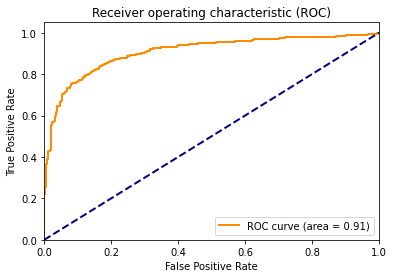

In [109]:
### START CODE HERE ### (2 lines)
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=test_values)
roc_auc = auc(fpr, tpr)
### END CODE HERE ###

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")

### 3.5 - Precision-Recall Curve (PRC)
We can do the exact same thing with precision and recall (instead of TPR and FPR), generating the precision-recall curve (PRC). Select the proper function from [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

Text(0.5, 1.0, 'Precision-Recall Curve (PRC)')

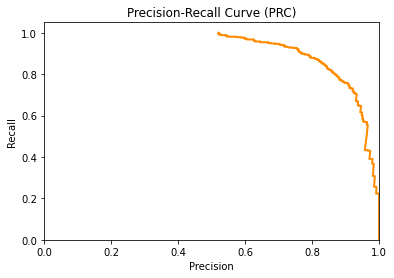

In [110]:
### START CODE HERE ### (1 line)
prec, rec, _ = precision_recall_curve(y_true=y_test, probas_pred=test_values)
### END CODE HERE ###

plt.figure()
plt.plot(prec, rec, color='darkorange', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall Curve (PRC)')

**Congratulations! Lab 4 completed :)**

What can you do now?
- This time we have not created an optimized input pipeline (there were already a lot of holes to fill...) but you can try to change the code and implement it as in Lab 3.
- We used a subset of the complete dataset available [here](https://github.com/basveeling/pcam). You can try to increase the number of training images to evaluate the performance of the Inception v4 neural network.
- For simplicity, we used only two sets, training, and test. Remember that in a real evaluation we need three sets: training, validation, and test. The validation set is used during training to select the best hyperparameters (number of layers, neurons per layer...) and the epoch where to stop training. The test set is used to assess the performance of the resulting network, and it is never used during training.